In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
import numpy as np
import torch

import skimage.io as io
import PIL.Image
from IPython.display import Image 


from helpers import CPU, CUDA, clip, GPT2Tokenizer
from helpers import ClipCaptionModel, generate2, generate_beam

from show import show_single_image, set_latex_fonts

# set_latex_fonts(usetex=False)

In [3]:
# Download the model weights

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'model_wieghts.pt')

pretrained_model = 'Conceptual captions'  # @param ['COCO', 'Conceptual captions']
file_id = {
    "Conceptual captions": "14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT",
    "COCO": "1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX",
}.get(pretrained_model)
file_dst = model_path

if not os.path.exists(model_path):
    print("Downloading the model weights...")
    !gdown --id $file_id -O $file_dst
    print("Model weights downloaded successfully.")
else:
    print(f"Model weights downloaded already at {model_path}.")

Model weights downloaded already at /home/pbagad/projects/CLIP_prefix_caption-video/pretrained_models/model_wieghts.pt.


In [4]:
# Set the device
is_gpu = True
device = CUDA(0) if is_gpu else "cpu"

In [5]:
# Load CLIP model and GPT tokenizer
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [6]:
# Load captioning model and load weights
prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval()
model = model.to(device)

In [7]:
# load sample image from UCF101 dataset

data_dir = "/ssd/pbagad/datasets/ucf101/"
frames_dir = os.path.join(data_dir, "rgb_frames/v_HighJump_g17_c04")
all_frames = glob(os.path.join(frames_dir, "*.jpg"))

selected_frame = all_frames[np.random.randint(len(all_frames))]

assert os.path.exists(selected_frame), f"{selected_frame} does not exist."

image = io.imread(selected_frame)
pil_image = PIL.Image.fromarray(image)
# display(pil_image)


In [8]:
# Generate caption

use_beam_search = False #@param {type:"boolean"}  

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)

# print('\n')
# print(generated_text_prefix)

100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


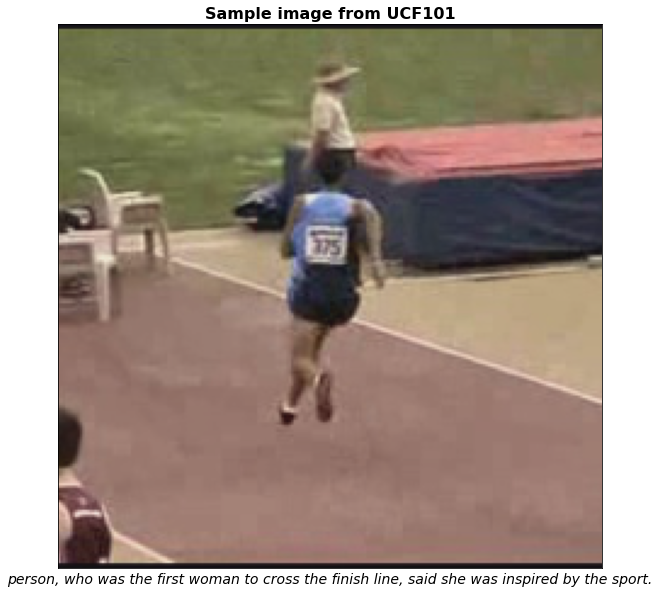

In [12]:
show_single_image(
    image[0].to(CPU),
    normalized=True,
    figsize=(10, 10),
    title="Sample image from UCF101",
    caption=generated_text_prefix,
)